In [24]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import theano.tensor as tt
import pandas as pd
from scipy import interpolate
sns.set(style='darkgrid', context='talk', color_codes=True)

In [14]:
def GetSigma(energy, dsNum=1):
    if dsNum==0:
        p0 = 0.147; p1=0.0173; p2=0.0003
    elif dsNum==1:
        p0 = 0.136; p1=0.0174; p2=0.00028
    elif dsNum==3:
        p0 = 0.162; p1=0.0172; p2=0.000297
    elif dsNum==4:
        p0 = 0.218; p1=0.015; p2=0.00035
    elif dsNum==5:
        p0 = 0.2121; p1=0.01838; p2=0.00031137
    else:
        p0 = 0.2121; p1=0.01838; p2=0.00031137
    return np.sqrt(p0*p0 + p1*p1*energy + p2*p2*energy*energy)

dsNum, dType = 1, "isNat"
inDir = '/Users/brianzhu/macros/code/Python/MCMC/Data'
# Data
df = pd.read_hdf('{}/DS{}_Spectrum_{}.h5'.format(inDir, dsNum, dType))

# Tritium PDF
dfTrit = pd.read_hdf('{}/TritSpec.h5'.format(inDir))
# Some values are negative (because Steve) so we need to fix it
# Also skip some values because the array is too granular
yTritium = dfTrit['Tritium'].values[1::2]
yTritium = np.array([x if x >= 0. else 0. for x in yTritium])
Energy = dfTrit['Energy'].values[1::2]

# Efficiency PDF
dfEff = pd.read_hdf('{}/DS{}_{}_Efficiency.h5'.format(inDir, dsNum, dType))
XEff = dfEff['Energy'].values
YEff = dfEff['Efficiency'].values

# Observable
Y = df['Energy'].values

# Peak means and sigmas
meansList = [6.54, 8.98, 10.37, 46.54]
sdList = [GetSigma(mean, dsNum) for mean in meansList]

Text(0,0.5,'Efficiency (%)')

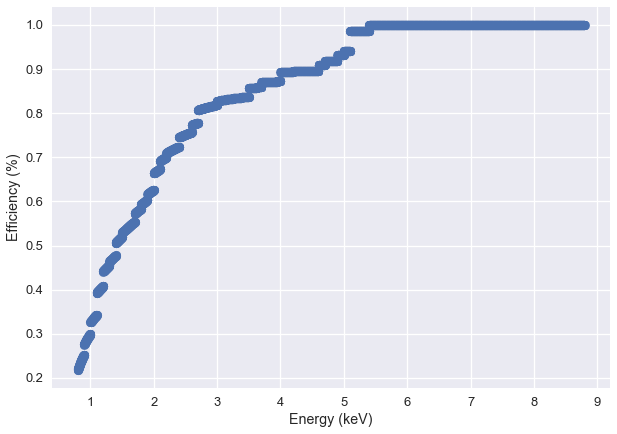

In [15]:
# Draw Efficiency -- This is a combination of Exposure*External Pulser cut efficiency
fig0, ax0 = plt.subplots(figsize=(10,7))
sns.regplot(x=XEff[:8000], y=YEff[:8000], fit_reg=False, ax=ax0)
ax0.set_xlabel('Energy (keV)')
ax0.set_ylabel('Efficiency (%)')

Text(0.5,0,'Energy (keV)')

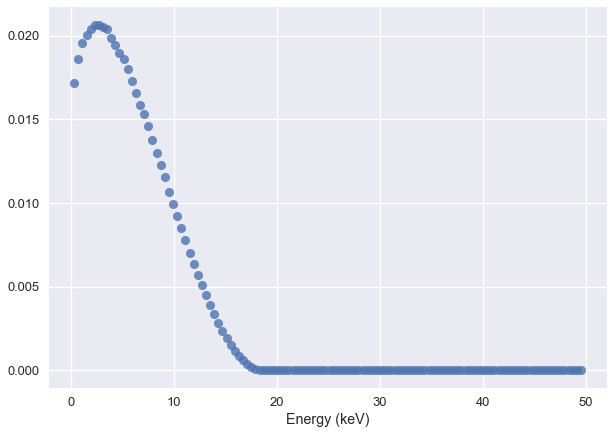

In [16]:
# Draw Tritium
fig1, ax1 = plt.subplots(figsize=(10,7))
sns.regplot(x=Energy, y=yTritium, fit_reg=False, ax=ax1)
ax1.set_xlabel('Energy (keV)')

124


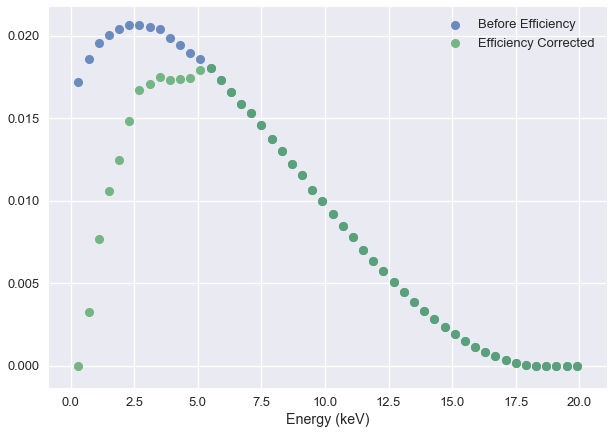

In [36]:
# Modify tritium with the efficiency, then plot
print(len(Energy))
fEff = interpolate.interp1d(XEff, YEff, fill_value='extrapolate')
TritEff = fEff(Energy)
TritEffy = TritEff*yTritium
fig2, ax2 = plt.subplots(figsize=(10,7))
sns.regplot(x=Energy[:50], y=yTritium[:50], fit_reg=False, ax=ax2, label='Before Efficiency')
sns.regplot(x=Energy[:50], y=TritEffy[:50], fit_reg=False, ax=ax2, label='Efficiency Corrected')
ax2.set_xlabel('Energy (keV)')
ax2.legend()

In [52]:
# Define mixture model
with pm.Model() as model:
    Fe55 = pm.Normal("Fe55", mu=meansList[0], sd=sdList[0])
    Zn65 = pm.Normal("Zn65", mu=meansList[1], sd=sdList[1])
    Ge68 = pm.Normal("Ge68", mu=meansList[2], sd=sdList[2])
    Pb210 = pm.Normal("Pb210", mu=meansList[3], sd=sdList[3])
    Bkg = pm.Uniform('Bkg', lower=2., upper=50.)
    Tritium = pm.Interpolated("Tritium", x_points=Energy, pdf_points=TritEffy, testval=5.)
    
    weights = pm.Dirichlet('weights', a=np.ones(len(meansList)+2))

    mix = pm.Mixture('mix', w=weights, comp_dists=[Fe55.distribution, Zn65.distribution, Ge68.distribution, Pb210.distribution, Tritium.distribution, Bkg.distribution], testval=5., observed=Y)
    

In [71]:
# Sample
with model:
    trace = pm.sample(draws=20000, n_init=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/brianzhu/anaconda/envs/py36/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights_stickbreaking__, Tritium_interval__, Bkg_interval__, Pb210, Ge68, Zn65, Fe55]
100%|██████████| 20500/20500 [01:25<00:00, 240.57it/s]
There were 574 divergences after tuning. Increase `target_accept` or reparameterize.
There were 507 divergences after tuning. Increase `target_accept` or reparameterize.
There were 596 divergences after tuning. Increase `target_accept` or reparameterize.
There were 655 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c35eddac8>,
      dtype=object)

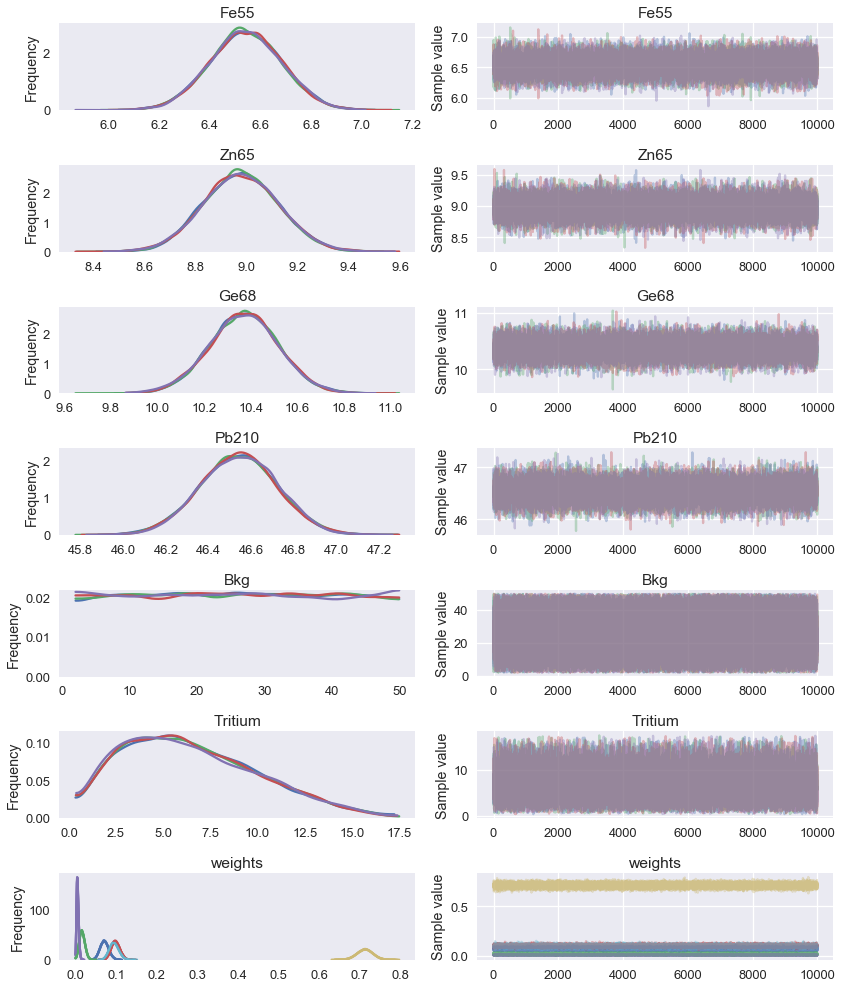

In [54]:
pm.traceplot(trace)

In [55]:
model.free_RVs

[Fe55,
 Zn65,
 Ge68,
 Pb210,
 Bkg_interval__,
 Tritium_interval__,
 weights_stickbreaking__]

In [56]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Fe55,6.540304,0.142055,0.000550,6.262420,6.816656,40000.0,1.000023
Zn65,8.978213,0.146763,0.000684,8.688070,9.259930,40000.0,0.999983
Ge68,10.369821,0.147256,0.000592,10.070133,10.649347,40000.0,1.000014
Pb210,46.540369,0.181660,0.000806,46.178132,46.888349,40000.0,0.999985
Bkg,25.987664,13.802420,0.054188,3.743592,49.211616,40000.0,0.999954
Tritium,6.580906,3.526090,0.014949,0.741770,13.236422,40000.0,1.000013
weights__0,0.071262,0.010421,0.000040,0.051841,0.092655,40000.0,0.999998
weights__1,0.016437,0.006726,0.000030,0.003749,0.029681,40000.0,0.999992
weights__2,0.098712,0.010512,0.000042,0.078323,0.119306,40000.0,0.999974
weights__3,0.005424,0.002554,0.000012,0.001020,0.010585,40000.0,0.999967


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c3818d6d8>,
      dtype=object)

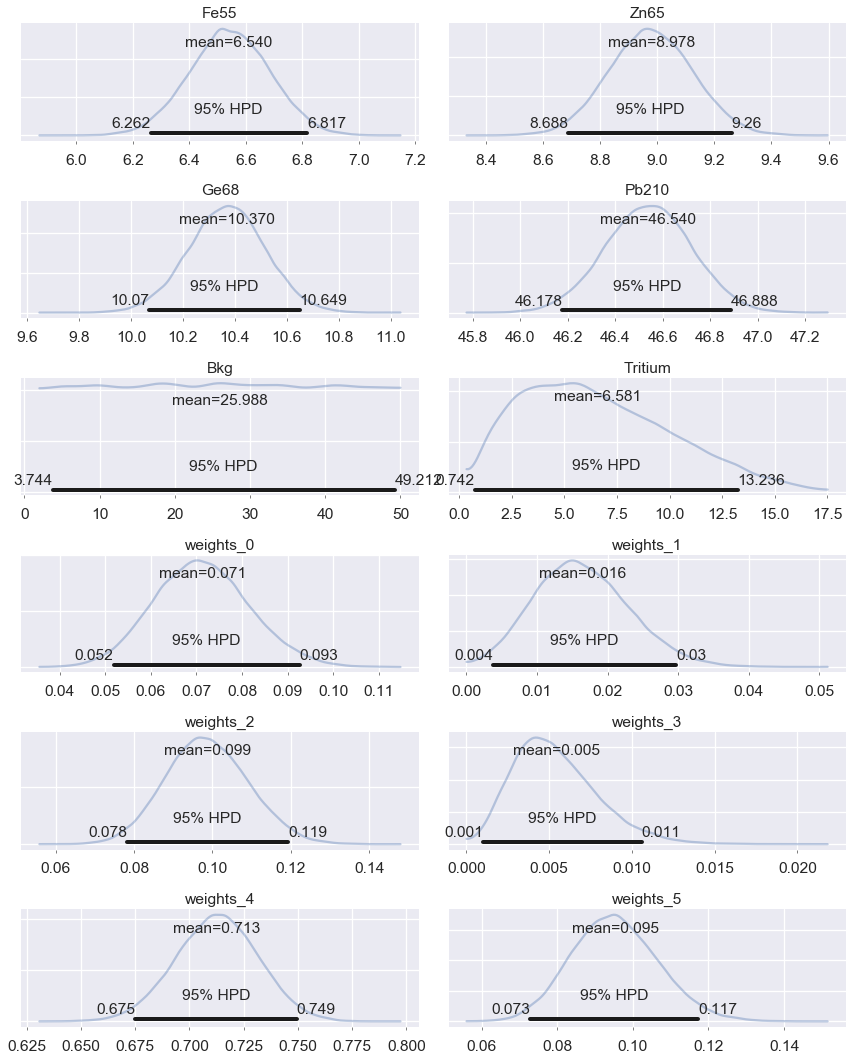

In [57]:
pm.plot_posterior(trace, kde_plot=True)

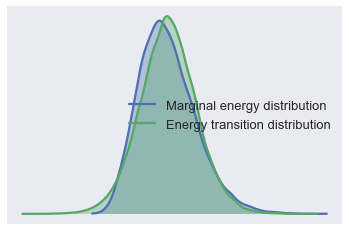

In [58]:
# Wtf is this?
pm.energyplot(trace)

In [61]:
print(trace['weights'][500:,0].mean())
print(trace['weights'][500:,1].mean())
print(trace['weights'][500:,2].mean())
print(trace['weights'][500:,3].mean())
print(trace['weights'][500:,4].mean())
print(trace['weights'][500:,5].mean())

fit_weights = [trace['weights'][500:,i].mean() for i in range(6)]
print(fit_weights)

0.07126053573007113
0.016435672867603272
0.09871404248179708
0.005421383625438726
0.712756697843549
0.09541166745154073
[0.07126053573007113, 0.016435672867603272, 0.09871404248179708, 0.005421383625438726, 0.712756697843549, 0.09541166745154073]


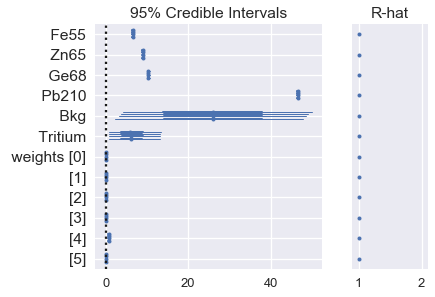

In [60]:
pm.forestplot(trace)

In [63]:
post_pred = pm.sample_ppc(trace, samples=500, model=model, size=1000)

100%|██████████| 500/500 [00:00<00:00, 659.00it/s]


In [64]:
post_pred['mix'].shape

(500, 1000)

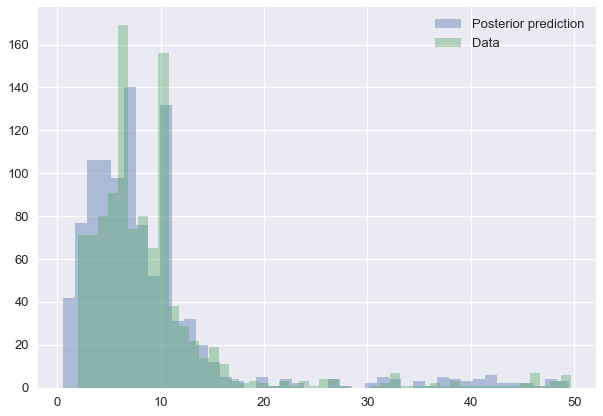

In [70]:
fig3, ax3 = plt.subplots(figsize=(10,7))
sns.distplot(post_pred['mix'][0,:], kde=False, label='Posterior prediction', ax=ax3)
sns.distplot(Y, kde=False, label='Data', ax=ax3)
ax3.legend()